# Imports, Constants, parameters, general functions 

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import circulant

# Data import 
DIR_PATH = "C:/Users/tobia/Desktop/Skole/KU_inverse_problems/Assignments/Assignment 2/"
DIR_PATH_IMAGE = DIR_PATH + "images/"

data = np.genfromtxt(DIR_PATH + "dataM.txt")

# Constants
N_bands = 200
mu0 = 1.25663706212e-6  # Unit: N / A**2. Vacuum permeability. 
h = 2e-2  # Unit: m. Height the magnetic field is measured at.
d_obs = data[:, 1] * 1e-9  # Unit: Tesla. Measured magnetic field.
std_d_obs = 25 * 1e-9  # Unit: Tesla. # Standard deviation of measured magnetic field data. 
x_band_obs = data[:, 0] * 1e-2  # Unit: m. Position of magnetic field measurements.
x_band = np.linspace(-50, 50, N_bands) * 1e-2  # Unit: m.
dx_band = 0.5e-2  # Unit: m
std_magnetization = 0.025  # Unit: A / m. Standard deviation of magnetization.

# General functions
def norm2(x):
    """Euclidean norm of a 1darray x"""
    return np.sqrt(np.sum(x**2))


def find_nearest(x, val):
    """Find the value in the array x that is closest to the given value val.

    Args:
        x (1darray): Data values
        val (float): Value we want an index in x close to.

    Returns:
        int: Index of the value in x closest to val
    """
    idx = np.abs(x - val).argmin()
    return idx

# Exercise 1
We are told the data is normally distributed i.e.:
    $$\rho_D(\textbf{d}) = k \exp{(-0.5 [\textbf{d}_{obs} - \textbf{d}]^\top  \textbf{C}_d^{-1}[\textbf{d}_{obs} - \textbf{d}])}$$
Where $k$ is a constant and $\textbf{C}_d$ is the covariance matrix of the data. In our case this is just the standard deviation on the collected data $\textbf{d}_{obs}$ (equal to $25$ nT). The likelihood is given by:
\begin{align}
    L(\textbf{m}) &= \rho_D(\textbf{d} = \textbf{G}\textbf{m})
        \\
    &= k \exp{(-0.5 [\textbf{d}_{obs} - \textbf{Gm}]^\top  \textbf{C}_d^{-1}[\textbf{d}_{obs} - \textbf{Gm}])}
\end{align}
Where $\textbf{m}$ is the model parameters i.e. the magnetization in the bands. The expression for the likelihood has been found

# Exercise 2

### Algorithm Outline

#### Helper functions

In [2]:
def magnetization_distribution():
    """Draw a random number from a Gaussian around 0 with standard deviation std_magnetization=0.025 A / m"""
    return np.random.normal(loc=0, scale=std_magnetization)  # Units: A / m


def find_stripe_widths(stripe_edges):
    """An array of stripe widths. Does not include their positions.

    Args:
        stripe_edges (1darray): Location of edges.
    Returns:
        (1darray): List of stripe widths
    """
    edges = np.nonzero(stripe_edges)[0]  # List of edge indices.
    width = edges[1:] - edges[:-1]  # Width is distance between edge indices
    return width


def find_width_positions(stripe_edges):
    """An array of stripe widths. All non-zero locations in the array are the width values corresponding to the edge at the same index.

    Args:
        stripe_edges (1darray): Location of edges.
    returns: 
        (1darray): N_bands long array where each non-zero entry is the width of the stripe at that location.
    """
    edges = np.nonzero(stripe_edges)[0]  # List of edge indices.
    width = edges[1:] - edges[:-1]  # Width is distance between edge indices
    stripe_width = 1 * stripe_edges
    stripe_width[edges[:-1]] = width  # Width from one edge to its right neigbour. Exclude right end point as it has no right neighbour.
    return stripe_width

#### The three update methods
- `change_magnetization_update_method` is the first of the three update methods.
- `change_boundary_update_method` contains the latter two methods.

In [3]:
def change_magnetization_update_method(magnetization, stripe_edges):
    """Update the magnetization values in a random stripe. The number of updated values is determined by finding the picked stripe's width.

    Args:
        magnetization (1darray): Magnetization array
        stripe_edges (1darray): Array of all the stripe edges
    Returns:
        (1darray, 1darray): Magnetization and stripe edges arrays after the update has been performed.
    """
    magnetization = magnetization.copy()
    stripe_edges = stripe_edges.copy()
    # Get random stripe to change magnetization in
    edges_coord_edge = np.nonzero(stripe_edges[:-1])[0]  # Get the edge indices in a list
    random_edge_idx = np.random.choice(a=edges_coord_edge)  # Choose a random edge from the list
    stripe_width = find_width_positions(stripe_edges)  # Find the stripe widths
    width_of_chosen_edge = int(stripe_width[random_edge_idx])
    
    # Update magnetization of the chosen edge
    magnetization[random_edge_idx: random_edge_idx + width_of_chosen_edge] = magnetization_distribution()
    
    return magnetization, stripe_edges
    

def change_boundary_update_method(magnetization, stripe_edges):
    """Attempt to either add or remove a boundary and update the magnetization accordingly

    Args:
        magnetization (1darray): Magnetization array
        stripe_edges (1darray): Stripe edges position array
        
    Returns:
        (1darray, 1darray): Magnetization and stripe edges arrays after the update has been performed.
    """
    magnetization = magnetization.copy()
    stripe_edges = stripe_edges.copy()
    # Pick random location and update its boundary
    p_boundary = 0.125
    rng = np.random.uniform(low=0, high=1)
    random_band_idx = np.random.randint(low=1, high=stripe_edges.size-1)  # Do not include end points as they should always be edges.    
    add_edge = p_boundary > rng and stripe_edges[random_band_idx] == 0  #  Add edge if the dice says so and there is no existing edge and...
    remove_edge = p_boundary < rng and stripe_edges[random_band_idx] == 1  # ... vice versa
    
    if add_edge:
        # Add edge and calculate distance to its to neighbouring edges such that can add new magnetizations to those
        stripe_edges[random_band_idx] = 1  # Add edge
        stripe_edges_edge_coord = np.nonzero(stripe_edges)[0]  # All edges in no 0's and 1's coordinate system. Do not include dtype
        random_band_idx_edge_coord = np.where(stripe_edges_edge_coord==random_band_idx)[0]  # Newly added edge in no 0's and 1's coordinate system.
        width_left = random_band_idx_edge_coord - stripe_edges_edge_coord[random_band_idx_edge_coord - 1]
        width_right = stripe_edges_edge_coord[random_band_idx_edge_coord + 1] - random_band_idx_edge_coord
        width_left = width_left[0]
        width_right = width_right[0]
                
        # Update magnetization
        magnetization[random_band_idx - width_left : random_band_idx] = magnetization_distribution() # Left
        magnetization[random_band_idx : random_band_idx + width_right] = magnetization_distribution()  # Right
                
    elif remove_edge:
        # Find distance to neighbours of the point that will be removed.
        # The left neighbour will then get a new magnetization value from itself plus the width of the previous neighbours.
        stripe_edges_edge_coord = np.nonzero(stripe_edges)[0]
        random_band_idx_edge_coord = np.where(stripe_edges_edge_coord==random_band_idx)[0]
        width_left = random_band_idx_edge_coord - stripe_edges_edge_coord[random_band_idx_edge_coord - 1]
        width_right = stripe_edges_edge_coord[random_band_idx_edge_coord + 1] - random_band_idx_edge_coord        
        width_left = width_left[0]
        width_right = width_right[0]

        # Update edges
        stripe_edges[random_band_idx] = 0
        
        # Update magnetization
        magnetization[random_band_idx - width_left: random_band_idx + width_right] = magnetization_distribution()
     
    return magnetization, stripe_edges

#### The prior algorithm

In [4]:
def prior_update_step(magnetization, stripe_edges):
    """Sample from the prior by updating the bands using one of three methods. 

    Args:
        magnetization (1darray): Array with the magnetization values at the N_bands x positions
        stripe_edges (1darray): Location of the stripe edges

    Returns:
        (1darray, 1darray): Magnetization and stripe edges arrays after the update has been performed.
    """
    m = magnetization.copy()
    edges = stripe_edges.copy()
    # Choose update each method with 50% chance
    change_magnetization = np.random.uniform(low=0, high=1) > 0.5
    if change_magnetization:
        m_new, edges_new = change_magnetization_update_method(m, edges)
    else:  # Change boundary
        m_new, edges_new = change_boundary_update_method(m, edges)
    return m_new, edges_new

#### Initialization using Tikhonov
We can use that the problem is linear to get a very good initial guess using Tikhonov.

In [5]:
def G_matrix():
    G = dx_band * (- mu0 / (2 * np.pi) * 
                   ((x_band_obs[:, None] - x_band[None, :]) ** 2 - h ** 2) 
                   / ((x_band_obs[:, None] - x_band[None, :]) ** 2 + h ** 2) ** 2 )
    return G


def prior_initialization(illustrate_find_eps=False):
    """Use Tikhonov regularization to initialize MCMC

    Args:
        illustrate_find_eps (bool): If true, shows a plot of the optimal epsilon value
    returns:
        (1darray, float): magnetization, optimal epsilon
    """
    # Calculate terms without epsilon for speeding up the loop
    G = G_matrix()   
    d = 1 * d_obs
    GTG = G.T @ G
    GTd = G.T @ d
    I = np.eye(GTG.shape[0])
    # Loop values
    eps_vals = np.linspace(1e-7, 1e-5, 100)
    loss_arr = np.zeros_like(eps_vals)
    # Find m and store loss
    for i, eps in tqdm(enumerate(eps_vals)):
        m = np.linalg.inv(GTG + eps ** 2 * I) @ GTd  # Tikhonov regularization expression
        misfit = norm2(d - G @ m) ** 2 
        loss = misfit - d.size * std_d_obs ** 2  # Should be zero for optimal epsilon
        loss_arr[i] = loss
    
    # Find optimal eps by loss intersection with 0
    loss_close_zero_idx = find_nearest(loss_arr, val=0)
    eps_optimal = eps_vals[loss_close_zero_idx]
    m_optimal = np.linalg.inv(GTG + eps_optimal ** 2 * I) @ GTd
    
    # Illustrate epsilon optial
    if illustrate_find_eps:
        fig, ax = plt.subplots(dpi=200)
        ax.plot(eps_vals, loss_arr, "-", label="Cost")
        ax.axhline(0, ls="dashed", lw="1", color="grey")
        ax.axvline(eps_optimal, ls="dashed", lw="1", color="grey", label=r"$\hat{\varepsilon}$")
        ax.set(xlabel=r"$\varepsilon$", ylabel=r"Cost $C(\varepsilon)$", title=r"Finding the optimal $\varepsilon$")
        ax.legend()
        fig.tight_layout()
        plt.savefig(DIR_PATH_IMAGE + f"optimal_eps{eps_optimal:.4f}.png")
        print("Optimal Tikhonov epsilon = ", eps_optimal)
        
    return m_optimal, eps_optimal

##### Visualize optimal epsilon for initialization

0it [00:00, ?it/s]

100it [00:02, 40.96it/s]


Optimal Tikhonov epsilon =  2.4999999999999998e-06


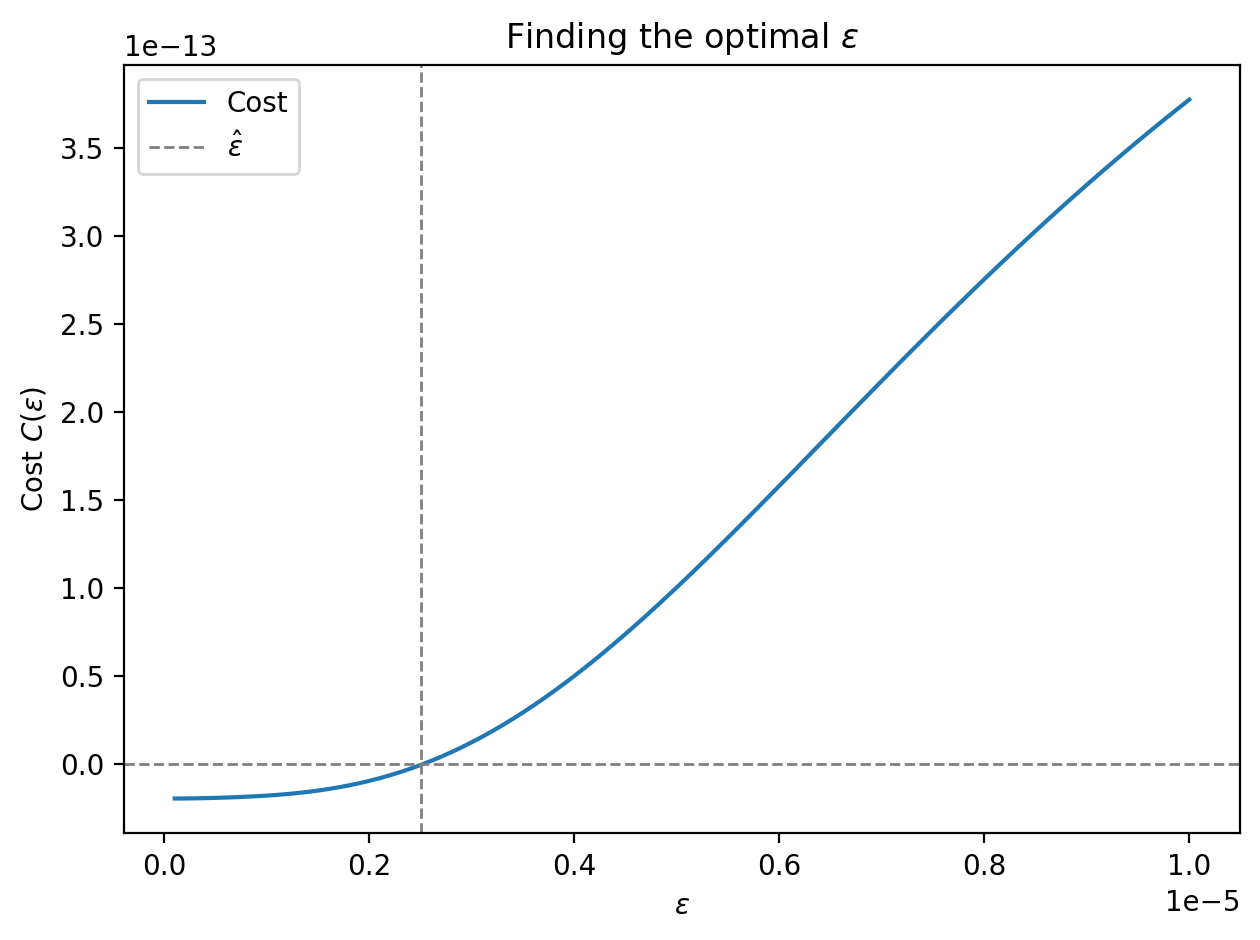

In [6]:
prior_initialization(illustrate_find_eps=True);

#### Visualize prior
Four arbitrary model parameters are shown. For this we need to sample the prior data.

In [7]:
def sample_prior_data(N_bands, N_step, burn_in_steps, skip_factor=1):
    """Returns prior sampeld magnetization"""
    # Iinitialization
    magnetization, _ = prior_initialization()
    mag_nbor_diff = magnetization[1:] - magnetization[:-1]
    stripe_edges = np.ones_like(magnetization)
    stripe_edges[1:] = np.where(mag_nbor_diff==0, 0, 1)
    
    # End points always an edge
    stripe_edges[0] = 1
    stripe_edges[-1] = 1
    
    m_hist = np.empty((N_bands, N_step))
    m_hist[:, 0] = magnetization
    m_save = []
    # Update
    for i in tqdm(range(1, N_step)):
        m = m_hist[:, i-1]
        m_new, stripe_edges = prior_update_step(m, stripe_edges)
        m_hist[:, i] = m_new
        
        if (i > burn_in_steps) and (i % skip_factor) == 0:
            m_save.append(m_new)

    return m_hist[:, burn_in_steps:]
    

def illustrate_four_prior_parameters(N_bands, N_step, burn_in_steps):
    """Histogram of the prior four model parameter. Should be Gaussianly distributed"""    
    # Get m values
    m = sample_prior_data(N_bands, N_step, burn_in_steps)
    m0 = m[0, :]
    m5 = m[5, :]
    m20 = m[20, :]
    m40 = m[40, :]
    
    # Histogram values
    N_bins = int(np.sqrt(m0.size))
    m0_count, m0_bins = np.histogram(m0, bins=N_bins)
    m5_count, m5_bins = np.histogram(m5, bins=N_bins)
    m20_count, m20_bins = np.histogram(m20, bins=N_bins)
    m40_count, m40_bins = np.histogram(m40, bins=N_bins)
    bin_width_arr = m0_bins[1:] - m0_bins[:-1]
    frequency = bin_width_arr[0] / N_bins
    freq_str_scientific_notation = np.format_float_scientific(frequency, precision=2, trim="-")
    
    # Plot values
    fig, ax = plt.subplots(dpi=150, ncols=2, nrows=2, layout="constrained")
    # m0 ax00
    ax[0, 0].stairs(m0_count, m0_bins)
    #ax[0, 0].plot(x_vals, y_pdf, "-")
    ax[0, 0].set(ylabel=f"Frequency ({freq_str_scientific_notation})", title=r"$m_0$")
    # m1 ax01
    ax[0, 1].stairs(m5_count, m5_bins)
    ax[0, 1].set(title=r"$m_5$")
    # m2 ax10
    ax[1, 0].stairs(m20_count, m20_bins)
    ax[1, 0].set(xlabel="Magnetization values", ylabel=f"Frequency ({freq_str_scientific_notation})", title=r"$m_{20}$")
    # m3 ax11
    ax[1, 1].stairs(m40_count, m40_bins)
    ax[1, 1].set(xlabel="Magnetization values", title=r"$m_{40}$")
    # Figure title
    suptitle = r"Four prior sample parameters, $N_{step}$ = " + str(N_step)
    fig.suptitle(suptitle)
    plt.show()

0it [00:00, ?it/s]

100it [00:02, 37.06it/s]
100%|██████████| 249999/249999 [00:06<00:00, 35857.33it/s]


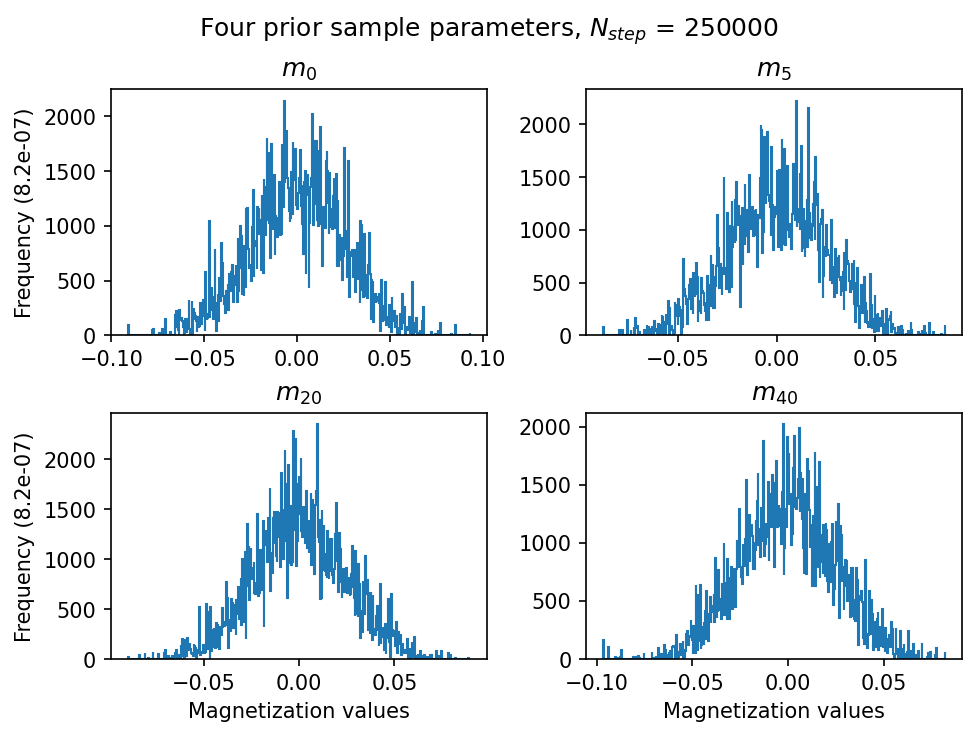

In [8]:
illustrate_four_prior_parameters(N_bands, N_step=250_000, burn_in_steps=25_000);

As seen on the graphs above, the prior seems to sample from the Gaussian: $m\sim N(\sigma=0.025, \mu=0)$. To be thorough, one could use a Kolmogorov Smirnov test on each of the magnetization positions.

# Exercise 3 - Null information

* text *

# Exercise 4 - MCMC Posterior

#### $\rho_D(\textbf{d}), L(\textbf{m})$ and acceptance ratio

In [9]:
def data_distribution(data):
    """The rho_D(data) distribution

    Args:
        data (1darray): Data values. Length equal to d_obs

    Returns:
        float: rho_D(data) given data
    """
    rho_d = np.exp(-0.5 * np.sum((data - d_obs) ** 2) / std_d_obs ** 2)    
    return rho_d


def likelihood(model_parameters):
    """Likelihood = rho_D(d = Gm)"""
    G = G_matrix()
    forward_solution = G @ model_parameters
    L = data_distribution(forward_solution)    
    return L


def acceptance_ratio(model_parameters_proposed, model_parameters_old):
    """Probability of accepting a proposed perturbation to model using misfit.

    Args:
        model_parameters_proposed (1darray): Proposed magnetization update.
        model_parameters_old (1darray): Old magnetization values.

    Returns:
        (float, float)): Acceptance probablity, misfit value of proposed step.
    """
    L_new = likelihood(model_parameters_proposed)
    L_old = likelihood(model_parameters_old)
    misfit_new = -np.log(L_new)
    misfit_old = -np.log(L_old)
    acceptance = np.exp(misfit_old - misfit_new)
    return np.min((1, acceptance)), misfit_new

#### The MCMC algorithm

In [10]:
def MCMC_posterior(N_bands, N_step, burn_in_steps):
    """Sample from posterior using MCMC

    Args:
        N_bands (_type_): _description_
        N_step (_type_): _description_
        burn_in_steps (_type_): _description_

    Returns:
        (1darray, 1darray): magnetization history, missfit history
    """
    # Initialize magnetization
    m_old, _ = prior_initialization()
    mag_nbor_diff = m_old[1:] - m_old[:-1]
    # Initialize edges
    stripe_edges_old = np.ones_like(m_old)
    stripe_edges_old[1:] = np.where(mag_nbor_diff==0, 0, 1)
    stripe_edges_old[0] = 1  # End points always an edge
    stripe_edges_old[-1] = 1
    
    # Store values
    m_hist = np.empty((N_bands, N_step))
    m_hist[:, 0] = m_old
    missfit_list = []
    # MCMC Iteration
    for i in tqdm(range(1, N_step)):
        m_old = m_hist[:, i-1]
        # Propose new step by sampling prior and check if new step is accepted using likelihoods
        m_proposed, stripe_edges_proposed = prior_update_step(m_old, stripe_edges_old)
        accept_ratio, misfit_proposed = acceptance_ratio(m_proposed, m_old)
        if accept_ratio > np.random.uniform(low=0, high=1):
            m_hist[:, i] = m_proposed
            stripe_edges_old = stripe_edges_proposed
            missfit_list.append(misfit_proposed)
        else:
            m_hist[:, i] = m_old
    
    return m_hist[:, burn_in_steps:], missfit_list

In [11]:
magnetization_history, misfit_history = MCMC_posterior(N_bands, N_step=1000_000, burn_in_steps=25_000)

0it [00:00, ?it/s]

100it [00:02, 46.67it/s]
  0%|          | 0/999999 [00:00<?, ?it/s]C:\Users\tobia\AppData\Local\Temp\ipykernel_14712\2684893576.py:34: RuntimeWarning: divide by zero encountered in log
  misfit_new = -np.log(L_new)
100%|██████████| 999999/999999 [02:21<00:00, 7072.07it/s]


#### Illustrate the G matrix used for initialization

In [12]:
def illustrate_G_matrix():
    """Illustrate the G matrix using imshow"""
    fig, ax = plt.subplots()
    G = G_matrix()
    ax.imshow(G, cmap="bone")
    ax.set(title="G matrix visualized", xlabel="x bands", ylabel="x data")
    plt.show()

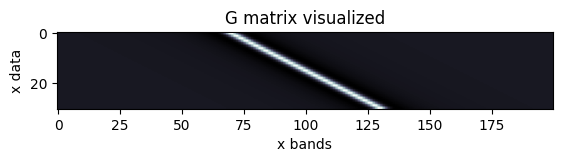

In [13]:
illustrate_G_matrix()

#### Illustrate burn in

In [39]:
def illustrate_burn_in(misfit):
    """Plot misfit over iterations to find the required steps to avoid burn in

    Args:
        misfit (1d array like): Misfit values from MCMC posterior sampling.
    """
    fig, ax = plt.subplots(dpi=200, ncols=1, nrows=2, layout="constrained")
    ax[0].plot(misfit)
    ax[0].set(ylabel="Misfit", title="Full range of misfit values")
    ax[1].plot(misfit[:50_000])
    ax[1].set(xlabel="Steps", ylabel="First 50.000 misfit values", title="Burn in period for MCMC")
    plt.show()

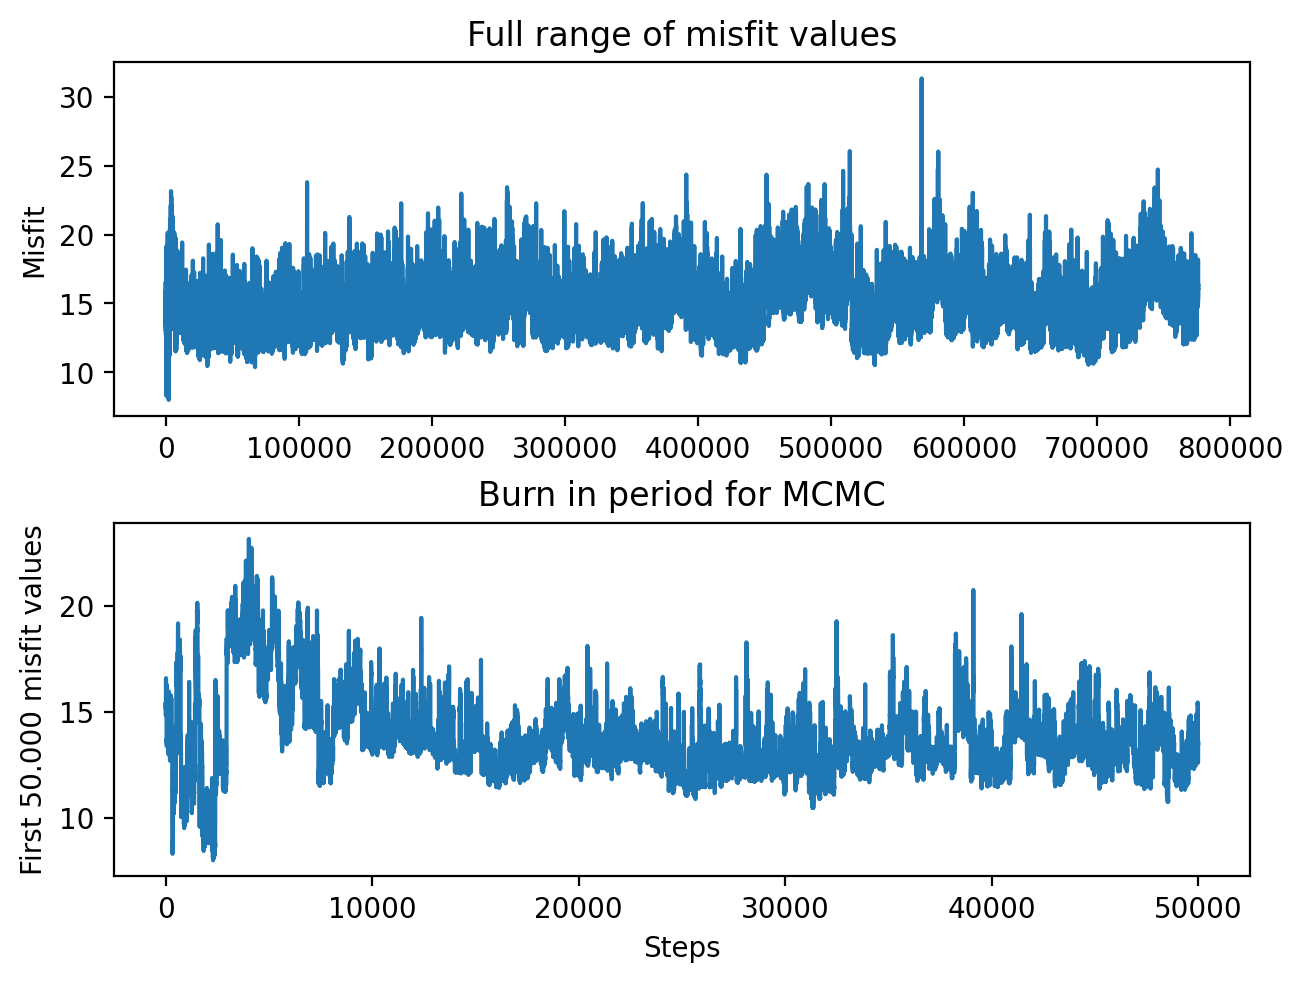

In [40]:
illustrate_burn_in(misfit_history)

#### Illustrate a single sample 

In [43]:
def illustrate_single_sample_posterior(mcmc_magnetization_output):
    """Illustrate a single sample of the MCMC posterior.

    Args:
        mcmc_magnetization_output (1darray): Magnetization values from MCMC sampling
    """
    # Get data
    m = mcmc_magnetization_output[:, -1]  # Only sample a single one, choose the last.
    G = G_matrix()
    Gm = G @ m
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(x_band_obs, Gm, label="posterior")
    ax.plot(x_band_obs, d_obs, label=r"$d_{obs}$")
    ax.set(xlabel="x", ylabel="Magnetization", title=r"Single sample posterior vs $d_{obs}$")
    ax.legend()
    plt.show()

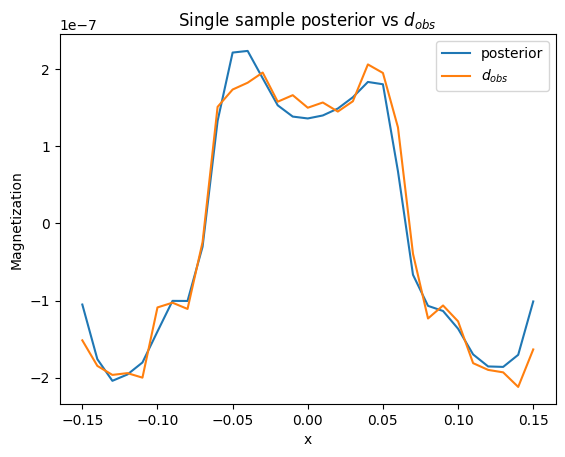

In [44]:
illustrate_single_sample_posterior(magnetization_history);

# Exercise 5 - Standard deviation
- Auto correlation function
- Distribution of each band's magnetization
- Standard deviation values

#### Illustrate auto correlation

In [51]:
def illustrate_auto_correlation(misfit_vals, k_max):
    """Calculate and plot autocorrelation using misfit values of accepted MCMC steps.

    Args:
        misfit_vals (1d arraylike): Misfit values from MCMC sampling steps that were accepted
        k_max (int): The max correlation length investigated
    """
    # Calculate autocorrelation
    # Shift misfit such that it oscillates around 0 by subtracting mean of data
    misfit = np.array(misfit_vals)
    misfit = misfit[int(misfit.size * 0): ]  # only include last 10% as otherwise gets memory allocation error
    misfit_mean = np.mean(misfit)
    misfit_shifted = misfit - misfit_mean
    
    autocorrelation = np.empty(k_max)
    rolled = misfit_shifted
    for k in range(k_max):
        rolled = np.roll(rolled, k)
        autocorrelation[k] = misfit_shifted[k:] @ rolled[k:]
        
    fig, ax = plt.subplots(dpi=200)
    ax.plot(autocorrelation)
    ax.axvline(x=260, ls="dashed", c="grey", label=r"$k=260$")
    ax.axhline(y=0, ls="dashed", c="grey")
    ax.set(xlabel="Correlation length", ylabel="Autocorrelation (unnormalized)", title="Finding correlation of MCMC random walk")
    ax.legend()
    plt.show()

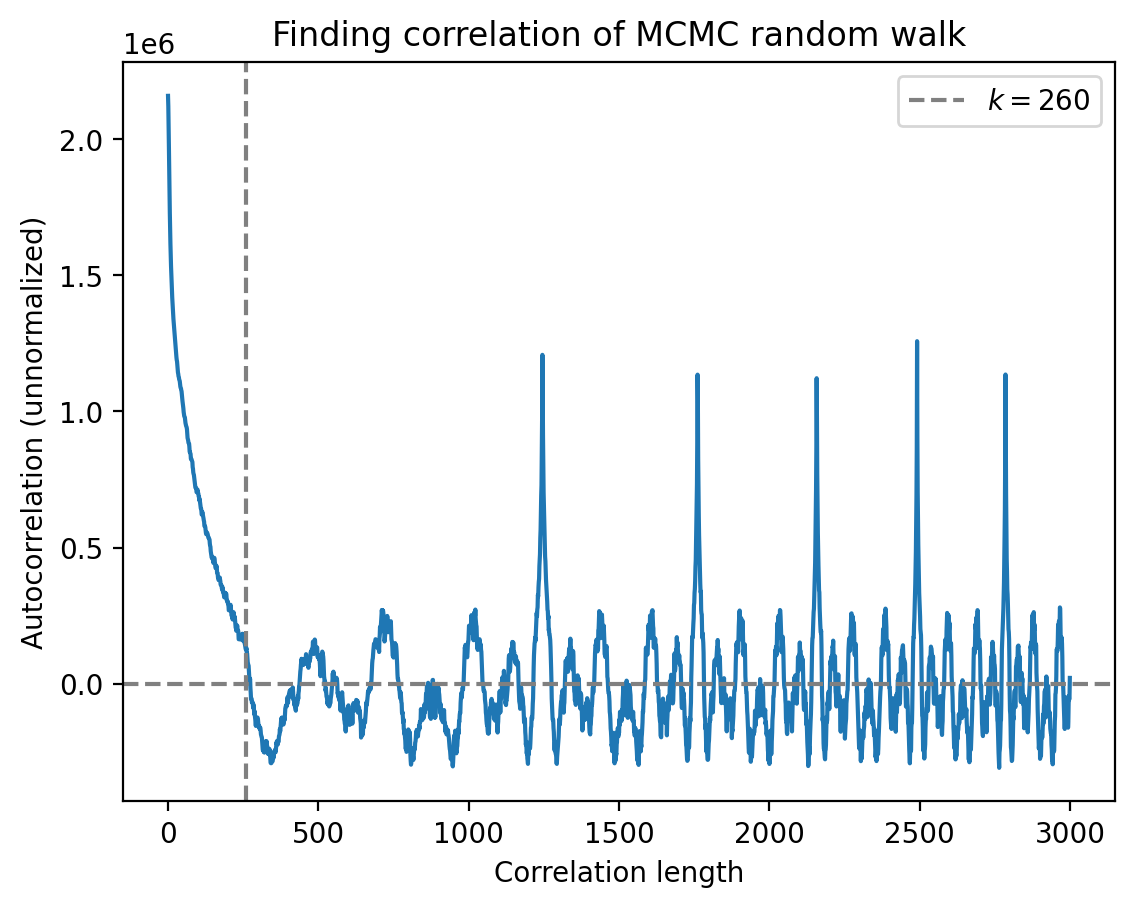

In [52]:
illustrate_auto_correlation(misfit_history, k_max=3000)

Something odd happens at high $k$ (correlation length) values where it seems like the autocorrelations starts oscillating with different frequencies and amplitudes. While not entirely representitative because it does not converge to $0$, I will use $k=260$ as the correlation length.

Looking at the full range misfit graph above, we do see that there is a slight oscilatory behavour at later iteration steps. 

#### Illustrate each location's magnetization distribution

In [88]:
def illustrate_posterior_mean_and_std(mcmc_magnetization_output, skip_elements=260):  # Exercise 5
    """Show the Gaussian distribution of each position's posterior magnetization value. Each point is the mean and the errorbar shows the size of one standard deviation.

    Args:
        mcmc_magnetization_output (1darray): Magnetization values from MCMC sampling
        skip_elements (int): 
    """
    # Gaussianly distributed 
    m = mcmc_magnetization_output[:, ::skip_elements]
    m_mean = np.mean(m, axis=1)
    m_std = np.std(m, axis=1)
    
    fig, ax = plt.subplots(dpi=200, ncols=1, nrows=2, layout="constrained")
    
    # ax0 mean w/errorbar
    ax[0].plot(x_band, m_mean, "k.", markersize=5, label=r"$\mu$")
    ax[0].plot(x_band, m_mean, "k-", lw=1)
    ax[0].errorbar(x_band, m_mean, yerr=m_std, fmt="k,", alpha=0.4, label=r"$\sigma$")
    ax[0].set(ylabel="Magnetization", title="Magnetization parameter distributions")
    ax[0].legend(loc="lower right")
    # ax1 std
    ax[1].plot(x_band, m_std, "k.", markersize=5, label=r"$\sigma$")
    ax[1].plot(x_band, m_std, "k-", lw=1)
    ax[1].set(xlabel="x", ylabel="Magnetization", title="Standard deviation distribution")
    ax[1].legend(loc="lower right")
    plt.show()

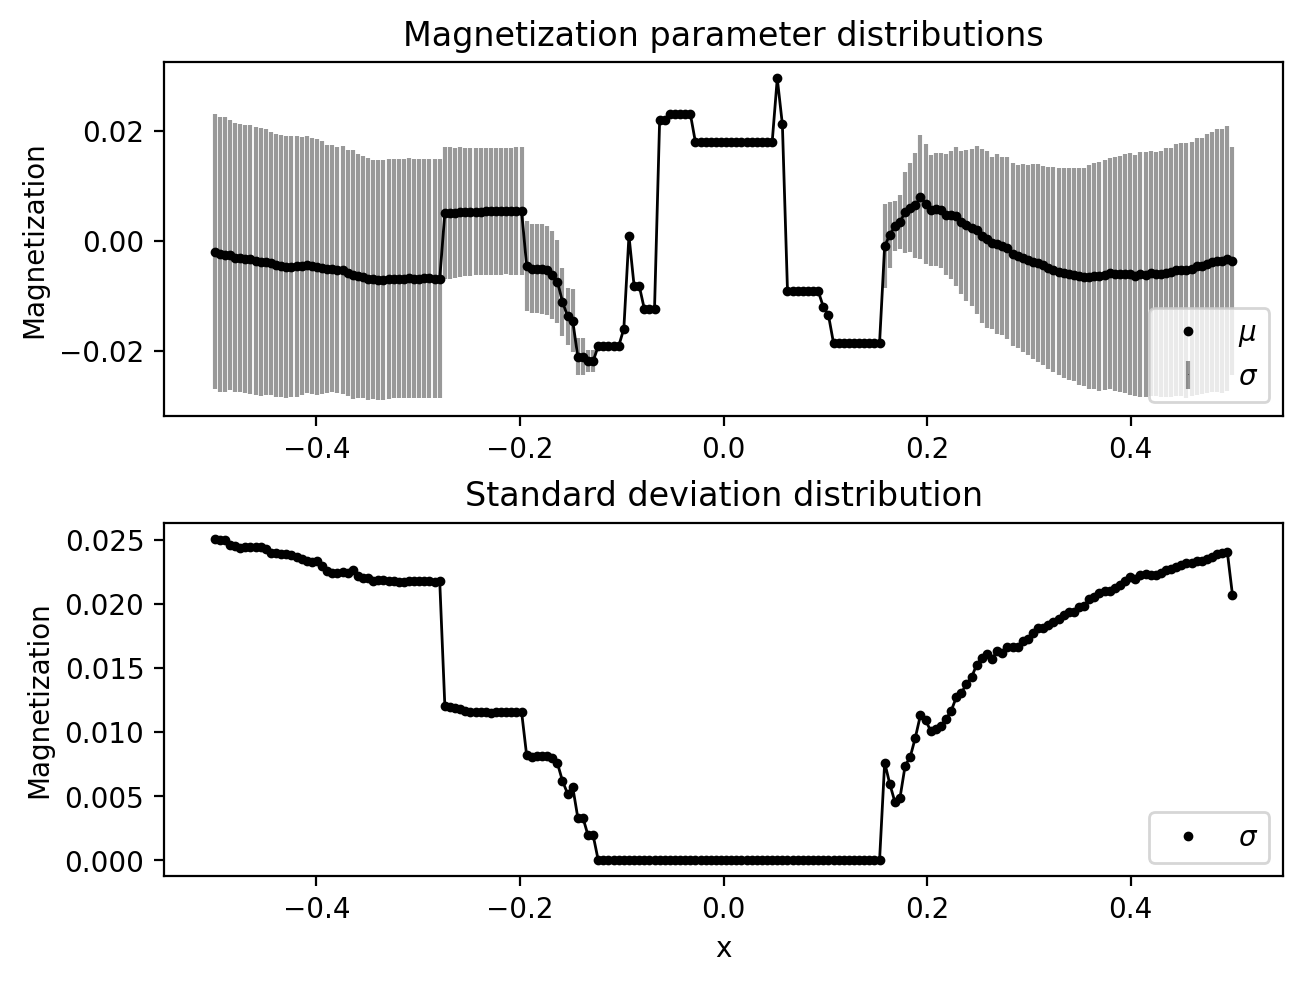

In [89]:
illustrate_posterior_mean_and_std(magnetization_history)

The upper graph shows the Gaussian distribution of each position's magnitization values. The black dots are the mean values, and the grey bars are the value of one standard deviation. The standard deviation is low in the $x$ range where we have a lot of information, $x \in [-0.15, 0.15]$ m, which stems from the collected data.  